In [1]:
!pip install transformers 
!pip install timm
!pip install monai
!pip install albumentations
!pip install torchmetrics


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 24.8 MB/s eta 0:00:0000:01


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# !pip install -q kaggle
# from google.colab import files
# files.upload()
# !mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets list

# !kaggle datasets download -d fakhrealam9537/leaf-disease-segmentation-dataset
# ! mkdir data
# ! unzip leaf-disease-segmentation-dataset.zip -d data

# !kaggle datasets download -d ntirupathirao18/leafdisease-image-id-split
# ! unzip leafdisease-image-id-split.zip -d data


#!kaggle datasets download -d vbookshelf/pneumothorax-chest-xray-images-and-masks
# ! mkdir data
# ! unzip pneumothorax-chest-xray-images-and-masks.zip -d data



In [20]:
import torch
import numpy as np
from torchvision import transforms
from torch import nn
from transformers import ConvNextConfig, UperNetConfig,ConvNextV2Config,AutoModel, UperNetForSemanticSegmentation, SwinConfig, Swinv2Config
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import ToTensor
from torchvision.models import segmentation
from torchvision.io import read_image
import os
from PIL import Image
import glob
import albumentations as A
import pandas as pd
import monai


In [5]:
def create_txtfile_fromcsv( path, output_path , out_name) :
    df = pd.read_csv(path)
    with open(os.path.join(output_path, out_name+'.txt'), 'w') as f:
        for line in list(df['new_filename']):
            f.write(f"{line}\n")

In [6]:


def create_model(name , num_classes , test_sample = True ) :

  if name == 'convnext' :
    backbone_config = ConvNextConfig(out_features=["stage1", "stage2", "stage3", "stage4"])
  if name == 'convnextv2' :  
    backbone_config = ConvNextV2Config(out_features=["stage1", "stage2", "stage3", "stage4"])
  if name == 'swin' :
    backbone_config = SwinConfig(out_features=["stage1", "stage2", "stage3", "stage4"])
    

  if name == 'internimage'  : 
    model = AutoModel.from_pretrained('OpenGVLab/internimage_t_1k_224' ,trust_remote_code = True ,
                                     
                                     )
    config = UperNetConfig()
    segmentation_model = UperNetForSemanticSegmentation(config)
    #segmentation_model.encoder = model.levels
    segmentation_model.backbone = model
    del segmentation_model.backbone.model.avgpool
    del segmentation_model.backbone.model.head
    
  else :
      config = UperNetConfig(backbone_config=backbone_config)
      #segmentation_model = UperNetForSemanticSegmentation.from_pretrained('openmmlab/upernet-convnext-tiny')
      segmentation_model = UperNetForSemanticSegmentation(config)

  
    
  

  in_channels = segmentation_model.decode_head.classifier.in_channels
  print(in_channels)
  # Number of output channels equal to number of classes
  
  output_channels = num_classes
  segmentation_model.decode_head.classifier = nn.Conv2d(512, output_channels, kernel_size=(1, 1), stride=(1, 1))
  segmentation_model.auxiliary_head.classifier = nn.Conv2d(256, output_channels, kernel_size=(1, 1), stride=(1, 1))

  if test_sample :
  # Verify the model output
      with torch.no_grad():
        seg_output = segmentation_model(torch.zeros(size= (4, 3, 224, 224)))

      print(seg_output.logits.shape)
  return segmentation_model 

In [7]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class SegDataset(Dataset):
    
    def __init__(self, parentDir, imageDir, maskDir):
        self.imageList = glob.glob(parentDir+'/'+imageDir+'/*')
        self.imageList.sort()
        self.maskList = glob.glob(parentDir+'/'+maskDir+'/*')
        self.maskList.sort()
    def __getitem__(self, index):
        
        preprocess = transforms.Compose([
                                    transforms.Resize((256,256), 2),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
        
        X = Image.open(self.imageList[index]).convert('RGB')
        X = preprocess(X)
        
        trfresize = transforms.Resize((256, 256), 2)
        trftensor = transforms.ToTensor()
        
        yimg = Image.open(self.maskList[index]).convert('L')
        y1 = trftensor(trfresize(yimg))
        y1 = y1.type(torch.BoolTensor)
        y2 = torch.bitwise_not(y1)
        y = torch.cat([y2, y1], dim=0)
        
        return X, y1.float()
            
    def __len__(self):
        return len(self.imageList)
    
class SegDataset_text(Dataset):
    
    def __init__(self, parentDir, imageDir, maskDir, txt_path , transforms_data , img_ext= '.jpg' , mask_ext = '.png'):
        with open(txt_path) as f:
            image_ids = f.readlines()
        #self.imageList = glob.glob(parentDir+'/'+imageDir+'/*')
        self.imageList = [os.path.join(parentDir , imageDir, indid.strip()+img_ext)for indid in image_ids ]
        self.imageList.sort()
        #self.maskList = glob.glob(parentDir+'/'+maskDir+'/*')
        self.maskList = [os.path.join(parentDir , maskDir, indid.strip()+mask_ext)for indid in image_ids ]
        self.maskList.sort()
        self.transforms_data = transforms_data
    def __getitem__(self, index):
        
#         preprocess = transforms.Compose([
#                                     transforms.Resize((256,256), 2),
#                                     transforms.ToTensor(),
#                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
        
#         X = Image.open(self.imageList[index]).convert('RGB')
#         X = preprocess(X)
        
#         trfresize = transforms.Resize((256, 256), 2)
#         trftensor = transforms.ToTensor()
        
#         yimg = Image.open(self.maskList[index]).convert('L')
#         y1 = trftensor(trfresize(yimg))
#         y1 = y1.type(torch.BoolTensor)
#         y2 = torch.bitwise_not(y1)
#         y = torch.cat([y2, y1], dim=0)
        
#         return X, y1.float()
        
        x = Image.open(self.imageList[index]).convert('RGB')
        yimg = Image.open(self.maskList[index]).convert('RGB')
        transform_images = self.transforms_data(image = np.array(x), mask = np.array(yimg))
        y1 = Image.fromarray(transform_images['mask']).convert('L')
        
        
#         y2 = torch.bitwise_not(y1)
#         y = torch.cat([y2, y1], dim=0)
        
        return torch.from_numpy(transform_images['image']/255.0).permute(2,0,1).to(torch.float32), torch.unsqueeze(torch.from_numpy(np.array(y1, dtype= 'bool')).float(),0).to(torch.float32)
        #return torch.from_numpy(transform_images['image']).permute(2,0,1).to(torch.float32), torch.unsqueeze(torch.from_numpy(np.array(y1, dtype= 'bool')).float(),0).to(torch.float32)
    def __len__(self):
        return len(self.imageList)
    


In [8]:
def train_model(model , no_of_epochs, check_point_dir , data_loader , name ) :
  # Define the loss function
  criterion = nn.BCEWithLogitsLoss()
  #criterion = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')
  # Define the optimizer
  optimizer = optim.Adam(model.parameters(), lr=0.0001)

  # Move the model to the device
  model = model.to(device)

  # Training loop
  epoch_loss_list = [1.0]

  for epoch in range(no_of_epochs):
      model.train()
      running_loss = 0.0

      for images, masks in data_loader:

          # Move images and masks to the device
          images = images.to(device)
          masks = masks.to(device)

          # Zero the gradients
          optimizer.zero_grad()

          # Forward pass
          outputs = model(images)['logits']

          #print(f"output shape: {outputs.shape}")

          # Compute the loss
          loss = criterion(outputs, masks)

          # Backward pass
          loss.backward()

          # Update the weights
          optimizer.step()

          # Update the running loss
          running_loss += loss.item() * images.size(0)
          """
          fig, axes = plt.subplots()
          axes.imshow(images[1].cpu().detach().numpy())
          show_mask(outputs[1].cpu().detach().numpy(), axes)
          
          print(f"image : {images}")
          print(f"mask : {masks}")
          print(f"outputs : {outputs}")
          """
          
          #print(loss.item())
      # Print the epoch loss
      epoch_loss = running_loss / len(data_loader)
      print(f"Epoch {epoch+1}/{no_of_epochs}, Loss: {epoch_loss:.4f}")

      if epoch_loss < min(epoch_loss_list)  :
        checkpoint_name = os.path.join(check_point_dir, f"{name}_model_epoch.pth") 
        torch.save(model.state_dict(), checkpoint_name)

      epoch_loss_list.append(epoch_loss)

      # if (epoch + 1) % 20 == 0:
      #     checkpoint_name = os.path.join(check_point_dir, f"{name}_model_epoch_{epoch}.pth") 
          
      #     # Save the model parameters
      #     torch.save(model.state_dict(), checkpoint_name)

  return model

In [9]:
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm 

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

def calculate_iou(predicted_mask, ground_truth_mask):
    # Threshold predicted mask to binary values
    predicted_mask = (predicted_mask > 0.5).float()

    # Calculate intersection and union
    intersection = torch.sum(predicted_mask * ground_truth_mask)
    union = torch.sum(predicted_mask) + torch.sum(ground_truth_mask) - intersection

    # Calculate IoU
    iou = intersection / (union + 1e-7)  # Add epsilon to avoid division by zero

    return iou


from torchmetrics.classification import BinaryJaccardIndex
def calculate_iou_v2(predicted_mask, ground_truth_mask , metric ): 
    return metric(predicted_mask, ground_truth_mask)

def train_validate_model(model , no_of_epochs, check_point_dir , train_data_loader , name , validation_data_loader) :
  # Define the loss function
    criterion = nn.BCEWithLogitsLoss()
    criterion = DiceBCELoss()
    criterion = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')
  # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

  # Move the model to the device
    model = model.to(device)
    metric_v2 = BinaryJaccardIndex().to(device)


  # Training loop
    epoch_loss_list = [1.0]

    for epoch in range(no_of_epochs):
        model.train()
        running_loss = 0.0
        print('epoch'+str(epoch) , end = '')

        for images, masks in tqdm(train_data_loader):

              # Move images and masks to the device
              images = images.to(device)
              masks = masks.to(device)

              # Zero the gradients
              optimizer.zero_grad()

              # Forward pass
              outputs = model(images)['logits']

              #print(f"output shape: {outputs.shape}")

              # Compute the loss
            
              loss = criterion(outputs, masks)

              # Backward pass
              loss.backward()

              # Update the weights
              optimizer.step()

              # Update the running loss
              running_loss += loss.item() * images.size(0)
              """
              fig, axes = plt.subplots()
              axes.imshow(images[1].cpu().detach().numpy())
              show_mask(outputs[1].cpu().detach().numpy(), axes)

              print(f"image : {images}")
              print(f"mask : {masks}")
              print(f"outputs : {outputs}")
              """

              #print(loss.item())
          # Print the epoch loss
        epoch_loss = running_loss / len(train_data_loader)

        if epoch_loss < min(epoch_loss_list)  :
            checkpoint_name = os.path.join(check_point_dir, f"{name}_model_v2_epoch.pth") 
            torch.save(model.state_dict(), checkpoint_name)

        epoch_loss_list.append(epoch_loss)

      ###########validation score with iou metric 
        model.eval()
        validation_metric = 0.0
        validation_metric_v2 = 0.0
    

        for images, masks in tqdm(validation_data_loader):

          # Move images and masks to the device
            images = images.to(device)
            masks = masks.to(device)
            target = model(images)['logits']
            predicted_mask = torch.sigmoid(target)

            metric = calculate_iou(predicted_mask,masks)
            validation_metric += metric.item() * images.size(0)
            #validation_metric = 0.0
            metric = calculate_iou_v2(predicted_mask,masks, metric_v2)
            validation_metric_v2 += metric.item() * images.size(0)


        total_metric_value = validation_metric / len(validation_data_loader)
        total_metric_value_v2 = validation_metric_v2 / len(validation_data_loader)

        print(f"Epoch {epoch+1}/{no_of_epochs}, Loss: {epoch_loss:.4f} , metric_IOU : {total_metric_value :.4f}, metric_IOU_v2 : {total_metric_value_v2 :.4f}" )

      # if (epoch + 1) % 20 == 0:
      #     checkpoint_name = os.path.join(check_point_dir, f"{name}_model_epoch_{epoch}.pth") 
          
      #     # Save the model parameters
      #     torch.save(model.state_dict(), checkpoint_name)

    return model

In [10]:

train_ratio = 0.7 
test_ratio = 0.3 
version = 2
import os 
dataset_src_path = r'/kaggle/input/leaf-disease-segmentation-dataset'
txt_src_path = r'/kaggle/input/leafdisease-image-id-split'
if version == 1 :
# Save the final trained model
  dataset = SegDataset(parentDir= os.path.join(dataset_src_path, 'data/data'),imageDir= "images", maskDir= "masks")
  # Calculate the sizes of training and testing sets
  train_size = int(train_ratio * len(dataset))
  test_size = len(dataset) - train_size

  # Randomly split the dataset into training and testing sets
  train_set, test_set = random_split(dataset, [train_size, test_size])
if version == 2 : 
    transforms_training = A.Compose([
                                    A.Resize(256,256),
                                    A.HorizontalFlip(p=0.5) , 
                                    A.RandomBrightnessContrast(p=0.2),
                                    A.RandomRotate90(),
                                    #A.Affine(scale=0.95, rotate = (0,30)),             
                                     #A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                      
                                  ])
          
    transforms_test = A.Compose([A.Resize(256,256), 
                                 #A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                  
                                    ])
        
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    train_set = SegDataset_text(parentDir= os.path.join(dataset_src_path, 'data/data'),imageDir= "images", maskDir= "masks" , 
                    txt_path = os.path.join(txt_src_path, 'train.txt'), 
                               transforms_data = transforms_training)
    test_set = SegDataset_text(parentDir=  os.path.join(dataset_src_path, 'data/data'),imageDir= "images", maskDir= "masks" , 
                    txt_path =os.path.join(txt_src_path, 'val.txt'), 
                              transforms_data = transforms_test)


# Create data loaders for training and testing sets
train_loader = DataLoader(train_set, batch_size=4, shuffle=True, num_workers=4)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [11]:

# train_ratio = 0.7 
# test_ratio = 0.3 
# version = 2
# import os 
# dataset_src_path = r'/kaggle/input/pneumothorax-chest-xray-images-and-masks/siim-acr-pneumothorax'
# train_csv_path = r'/kaggle/input/pneumothorax-chest-xray-images-and-masks/siim-acr-pneumothorax/stage_1_train_images.csv'
# test_csv_path = r'/kaggle/input/pneumothorax-chest-xray-images-and-masks/siim-acr-pneumothorax/stage_1_test_images.csv'
# output_path = r'/kaggle/working/'
# resize_image = [512,512]
# create_txtfile_fromcsv( train_csv_path, output_path , out_name = 'train')
# create_txtfile_fromcsv( test_csv_path, output_path , out_name = 'val')
# if version == 1 :
# # Save the final trained model
#   dataset = SegDataset(parentDir= os.path.join(dataset_src_path),imageDir= "png_images", maskDir= "png_masks")
#   # Calculate the sizes of training and testing sets
#   train_size = int(train_ratio * len(dataset))
#   test_size = len(dataset) - train_size

#   # Randomly split the dataset into training and testing sets
#   train_set, test_set = random_split(dataset, [train_size, test_size])
# if version == 2 : 
#     transforms_training = A.Compose([
#                                     A.Resize(resize_image[0],resize_image[1]),
#                                     A.HorizontalFlip(p=0.5) , 
#                                     A.RandomBrightnessContrast(p=0.2),
#                                     A.Affine(scale=0.95, rotate = (0,30)),
                                     
#                                      #A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                      
#                                   ])
          
#     transforms_test = A.Compose([A.Resize(resize_image[0],resize_image[1]),
#                                  #A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                  
#                                     ])
        
# #     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#     train_set = SegDataset_text(parentDir=os.path.join(dataset_src_path),imageDir= "png_images", maskDir= "png_masks", 
#                     txt_path = os.path.join(output_path, 'train.txt'), 
#                                transforms_data = transforms_training, img_ext= '' , mask_ext = '')
#     test_set = SegDataset_text(parentDir=  os.path.join(dataset_src_path),imageDir= "png_images", maskDir= "png_masks" , 
#                     txt_path =os.path.join(output_path, 'val.txt'), 
#                               transforms_data = transforms_test, img_ext= '' , mask_ext = '')


# # Create data loaders for training and testing sets
# train_loader = DataLoader(train_set, batch_size=4, shuffle=True, num_workers=2)
# test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

torch.Size([4, 1, 256, 256]) tensor([1., 1., 1.,  ..., 1., 1., 1.]) torch.float32
tensor([0.4353, 0.4627, 0.4549,  ..., 0.5294, 0.4784, 0.3922])


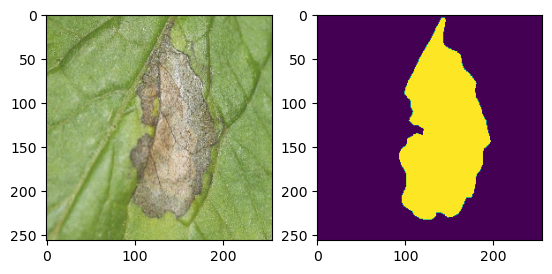

In [12]:
iter_train_loader = iter(train_loader)
sample = next(iter_train_loader) 
from matplotlib import pyplot as plt
print(sample[1].shape, sample[1][0,:,:][sample[1][0,:,:] > 0] , sample[0].dtype)
print(sample[0][0,:,:,:][sample[0][0,:,:,:] > 0 ])
plt.subplot(121),plt.imshow(sample[0][0,:,:,:].permute(1,2,0))
plt.subplot(122),plt.imshow(sample[1][0,:,:,:].permute(1,2,0))
plt.show()

In [13]:
# name = 'internimage'
# num_classes = 1 
# output_path = r'/kaggle/working'
# model = create_model(name , num_classes,test_sample =False  ) 

In [14]:
# model

In [15]:
# with torch.no_grad():
#     seg_output = model(torch.zeros(size= (4, 3, 224, 224)))

#     print(model.logits.shape)

In [16]:
# model

In [17]:
# model

In [18]:
# for name, param in model.named_parameters():
# #     if "classifier" not in name:
# #         param.requires_grad = False
#     print(name, param.requires_grad)

In [ ]:
name = 'convnext'
num_classes = 1 
output_path = r'/kaggle/working'
model = create_model(name , num_classes ) 
#model.load_state_dict(torch.load(r'/kaggle/working/convnext_model_v2_epoch.pth'))
# model = train_model_(model , no_of_epochs = 700, check_point_dir = '/content/drive/MyDrive/model' ,  data_loader = train_loader , name = name) 
model = train_validate_model(model , no_of_epochs = 700, check_point_dir = output_path ,  
                             train_data_loader = train_loader , name = name , 
                             validation_data_loader = test_loader) 

torch.save(model.state_dict(), name+"_leaf_Disease.pth")

512
torch.Size([4, 1, 224, 224])
epoch0

  0%|          | 0/103 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 177/177 [00:07<00:00, 23.09it/s]


Epoch 1/700, Loss: 1.9633 , metric_IOU : 0.3130, metric_IOU_v2 : 0.3130
epoch1

100%|██████████| 177/177 [00:06<00:00, 28.75it/s]


Epoch 2/700, Loss: 1.7457 , metric_IOU : 0.3972, metric_IOU_v2 : 0.3972
epoch2

100%|██████████| 177/177 [00:06<00:00, 28.55it/s]


Epoch 3/700, Loss: 1.6206 , metric_IOU : 0.4339, metric_IOU_v2 : 0.4339
epoch3

100%|██████████| 177/177 [00:06<00:00, 28.57it/s]


Epoch 4/700, Loss: 1.5725 , metric_IOU : 0.4052, metric_IOU_v2 : 0.4052
epoch4

100%|██████████| 177/177 [00:06<00:00, 28.04it/s]


Epoch 5/700, Loss: 1.5147 , metric_IOU : 0.4242, metric_IOU_v2 : 0.4242
epoch5

100%|██████████| 177/177 [00:06<00:00, 27.35it/s]


Epoch 6/700, Loss: 1.4888 , metric_IOU : 0.3690, metric_IOU_v2 : 0.3690
epoch6

100%|██████████| 177/177 [00:06<00:00, 28.18it/s]


Epoch 7/700, Loss: 1.4581 , metric_IOU : 0.3029, metric_IOU_v2 : 0.3029
epoch7

100%|██████████| 177/177 [00:06<00:00, 28.42it/s]


Epoch 8/700, Loss: 1.4407 , metric_IOU : 0.4611, metric_IOU_v2 : 0.4611
epoch8

100%|██████████| 177/177 [00:06<00:00, 28.32it/s]


Epoch 9/700, Loss: 1.4174 , metric_IOU : 0.0829, metric_IOU_v2 : 0.0829
epoch9

100%|██████████| 177/177 [00:06<00:00, 29.26it/s]


Epoch 10/700, Loss: 1.4278 , metric_IOU : 0.4553, metric_IOU_v2 : 0.4553
epoch10

100%|██████████| 177/177 [00:06<00:00, 27.07it/s]


Epoch 11/700, Loss: 1.3778 , metric_IOU : 0.2594, metric_IOU_v2 : 0.2594
epoch11

100%|██████████| 177/177 [00:06<00:00, 28.43it/s]


Epoch 12/700, Loss: 1.3465 , metric_IOU : 0.4826, metric_IOU_v2 : 0.4826
epoch12

100%|██████████| 177/177 [00:06<00:00, 28.19it/s]


Epoch 13/700, Loss: 1.3154 , metric_IOU : 0.4466, metric_IOU_v2 : 0.4466
epoch13

100%|██████████| 177/177 [00:06<00:00, 27.08it/s]


Epoch 14/700, Loss: 1.3001 , metric_IOU : 0.2665, metric_IOU_v2 : 0.2665
epoch14

100%|██████████| 177/177 [00:06<00:00, 27.09it/s]


Epoch 15/700, Loss: 1.3011 , metric_IOU : 0.4499, metric_IOU_v2 : 0.4499
epoch15

100%|██████████| 177/177 [00:06<00:00, 27.46it/s]


Epoch 16/700, Loss: 1.3084 , metric_IOU : 0.4608, metric_IOU_v2 : 0.4608
epoch16

100%|██████████| 177/177 [00:06<00:00, 27.82it/s]


Epoch 17/700, Loss: 1.3099 , metric_IOU : 0.5078, metric_IOU_v2 : 0.5078
epoch17

100%|██████████| 177/177 [00:06<00:00, 28.07it/s]


Epoch 18/700, Loss: 1.2972 , metric_IOU : 0.4901, metric_IOU_v2 : 0.4901
epoch18

100%|██████████| 177/177 [00:06<00:00, 28.69it/s]


Epoch 19/700, Loss: 1.2678 , metric_IOU : 0.4717, metric_IOU_v2 : 0.4717
epoch19

100%|██████████| 177/177 [00:06<00:00, 27.23it/s]


Epoch 20/700, Loss: 1.2389 , metric_IOU : 0.4265, metric_IOU_v2 : 0.4265
epoch20

100%|██████████| 177/177 [00:06<00:00, 28.30it/s]


Epoch 21/700, Loss: 1.2209 , metric_IOU : 0.4305, metric_IOU_v2 : 0.4305
epoch21

100%|██████████| 177/177 [00:06<00:00, 28.33it/s]


Epoch 22/700, Loss: 1.2228 , metric_IOU : 0.4609, metric_IOU_v2 : 0.4609
epoch22

100%|██████████| 177/177 [00:06<00:00, 28.18it/s]


Epoch 23/700, Loss: 1.1980 , metric_IOU : 0.5005, metric_IOU_v2 : 0.5005
epoch23

100%|██████████| 177/177 [00:06<00:00, 28.19it/s]


Epoch 24/700, Loss: 1.1691 , metric_IOU : 0.4547, metric_IOU_v2 : 0.4547
epoch24

100%|██████████| 177/177 [00:06<00:00, 26.80it/s]


Epoch 25/700, Loss: 1.1789 , metric_IOU : 0.4468, metric_IOU_v2 : 0.4468
epoch25

100%|██████████| 177/177 [00:06<00:00, 28.85it/s]


Epoch 26/700, Loss: 1.1548 , metric_IOU : 0.4776, metric_IOU_v2 : 0.4776
epoch26

100%|██████████| 177/177 [00:06<00:00, 28.64it/s]


Epoch 27/700, Loss: 1.1651 , metric_IOU : 0.4919, metric_IOU_v2 : 0.4919
epoch27

100%|██████████| 177/177 [00:06<00:00, 28.65it/s]


Epoch 28/700, Loss: 1.1269 , metric_IOU : 0.4510, metric_IOU_v2 : 0.4510
epoch28

100%|██████████| 177/177 [00:06<00:00, 27.46it/s]


Epoch 29/700, Loss: 1.1405 , metric_IOU : 0.4924, metric_IOU_v2 : 0.4924
epoch29

100%|██████████| 177/177 [00:06<00:00, 27.79it/s]


Epoch 30/700, Loss: 1.0883 , metric_IOU : 0.4775, metric_IOU_v2 : 0.4775
epoch30

100%|██████████| 177/177 [00:06<00:00, 28.42it/s]


Epoch 31/700, Loss: 1.0809 , metric_IOU : 0.4901, metric_IOU_v2 : 0.4901
epoch31

100%|██████████| 177/177 [00:06<00:00, 27.92it/s]


Epoch 32/700, Loss: 1.0890 , metric_IOU : 0.4090, metric_IOU_v2 : 0.4090
epoch32

100%|██████████| 177/177 [00:06<00:00, 28.93it/s]


Epoch 33/700, Loss: 1.0358 , metric_IOU : 0.3992, metric_IOU_v2 : 0.3992
epoch33

100%|██████████| 177/177 [00:06<00:00, 28.34it/s]


Epoch 34/700, Loss: 1.0379 , metric_IOU : 0.4746, metric_IOU_v2 : 0.4746
epoch34

100%|██████████| 177/177 [00:06<00:00, 28.47it/s]


Epoch 35/700, Loss: 1.0650 , metric_IOU : 0.5049, metric_IOU_v2 : 0.5049
epoch35

100%|██████████| 177/177 [00:06<00:00, 28.96it/s]


Epoch 36/700, Loss: 1.0205 , metric_IOU : 0.3271, metric_IOU_v2 : 0.3271
epoch36

100%|██████████| 177/177 [00:06<00:00, 29.16it/s]


Epoch 37/700, Loss: 1.0326 , metric_IOU : 0.4219, metric_IOU_v2 : 0.4219
epoch37

100%|██████████| 177/177 [00:06<00:00, 29.06it/s]


Epoch 38/700, Loss: 1.0546 , metric_IOU : 0.5224, metric_IOU_v2 : 0.5224
epoch38

100%|██████████| 177/177 [00:06<00:00, 27.11it/s]


Epoch 39/700, Loss: 1.0193 , metric_IOU : 0.4989, metric_IOU_v2 : 0.4989
epoch39

100%|██████████| 177/177 [00:06<00:00, 28.95it/s]


Epoch 40/700, Loss: 0.9435 , metric_IOU : 0.4996, metric_IOU_v2 : 0.4996
epoch40

100%|██████████| 177/177 [00:06<00:00, 29.29it/s]


Epoch 41/700, Loss: 0.9789 , metric_IOU : 0.4273, metric_IOU_v2 : 0.4273
epoch41

100%|██████████| 177/177 [00:06<00:00, 29.23it/s]


Epoch 42/700, Loss: 0.9517 , metric_IOU : 0.4506, metric_IOU_v2 : 0.4506
epoch42

100%|██████████| 177/177 [00:06<00:00, 29.14it/s]


Epoch 43/700, Loss: 0.9644 , metric_IOU : 0.4455, metric_IOU_v2 : 0.4455
epoch43

100%|██████████| 177/177 [00:06<00:00, 27.69it/s]


Epoch 44/700, Loss: 0.9465 , metric_IOU : 0.4769, metric_IOU_v2 : 0.4769
epoch44

100%|██████████| 177/177 [00:06<00:00, 28.88it/s]


Epoch 45/700, Loss: 0.9122 , metric_IOU : 0.5067, metric_IOU_v2 : 0.5067
epoch45

100%|██████████| 177/177 [00:06<00:00, 28.75it/s]


Epoch 46/700, Loss: 0.8955 , metric_IOU : 0.5086, metric_IOU_v2 : 0.5086
epoch46

100%|██████████| 177/177 [00:06<00:00, 28.78it/s]


Epoch 47/700, Loss: 0.9184 , metric_IOU : 0.5058, metric_IOU_v2 : 0.5058
epoch47

100%|██████████| 177/177 [00:06<00:00, 28.84it/s]


Epoch 48/700, Loss: 0.9099 , metric_IOU : 0.4830, metric_IOU_v2 : 0.4830
epoch48

100%|██████████| 177/177 [00:06<00:00, 27.43it/s]


Epoch 49/700, Loss: 0.8872 , metric_IOU : 0.5143, metric_IOU_v2 : 0.5143
epoch49

100%|██████████| 177/177 [00:06<00:00, 28.81it/s]


Epoch 50/700, Loss: 0.8721 , metric_IOU : 0.4356, metric_IOU_v2 : 0.4356
epoch50

100%|██████████| 177/177 [00:06<00:00, 29.24it/s]


Epoch 51/700, Loss: 0.9313 , metric_IOU : 0.5321, metric_IOU_v2 : 0.5321
epoch51

100%|██████████| 177/177 [00:06<00:00, 28.86it/s]


Epoch 52/700, Loss: 0.8589 , metric_IOU : 0.4255, metric_IOU_v2 : 0.4255
epoch52

100%|██████████| 177/177 [00:06<00:00, 27.55it/s]


Epoch 53/700, Loss: 0.8590 , metric_IOU : 0.5168, metric_IOU_v2 : 0.5168
epoch53

100%|██████████| 177/177 [00:06<00:00, 28.26it/s]


Epoch 54/700, Loss: 0.8461 , metric_IOU : 0.4854, metric_IOU_v2 : 0.4854
epoch54

100%|██████████| 177/177 [00:06<00:00, 28.94it/s]


Epoch 55/700, Loss: 0.8338 , metric_IOU : 0.4890, metric_IOU_v2 : 0.4890
epoch55

100%|██████████| 177/177 [00:06<00:00, 28.82it/s]


Epoch 56/700, Loss: 0.7615 , metric_IOU : 0.4183, metric_IOU_v2 : 0.4183
epoch56

100%|██████████| 177/177 [00:06<00:00, 29.20it/s]


Epoch 57/700, Loss: 0.8189 , metric_IOU : 0.4852, metric_IOU_v2 : 0.4852
epoch57

100%|██████████| 177/177 [00:06<00:00, 27.60it/s]


Epoch 58/700, Loss: 0.7805 , metric_IOU : 0.4258, metric_IOU_v2 : 0.4258
epoch58

100%|██████████| 177/177 [00:06<00:00, 29.20it/s]


Epoch 59/700, Loss: 0.7860 , metric_IOU : 0.5049, metric_IOU_v2 : 0.5049
epoch59

100%|██████████| 177/177 [00:06<00:00, 28.79it/s]


Epoch 60/700, Loss: 0.7914 , metric_IOU : 0.5464, metric_IOU_v2 : 0.5464
epoch60

100%|██████████| 177/177 [00:06<00:00, 28.91it/s]


Epoch 61/700, Loss: 0.7646 , metric_IOU : 0.4934, metric_IOU_v2 : 0.4934
epoch61

100%|██████████| 177/177 [00:06<00:00, 29.33it/s]


Epoch 62/700, Loss: 0.7923 , metric_IOU : 0.4778, metric_IOU_v2 : 0.4778
epoch62

100%|██████████| 177/177 [00:06<00:00, 27.01it/s]


Epoch 63/700, Loss: 0.7156 , metric_IOU : 0.4618, metric_IOU_v2 : 0.4618
epoch63

100%|██████████| 177/177 [00:06<00:00, 27.02it/s]


Epoch 64/700, Loss: 0.7636 , metric_IOU : 0.4421, metric_IOU_v2 : 0.4421
epoch64

100%|██████████| 177/177 [00:06<00:00, 29.24it/s]


Epoch 65/700, Loss: 0.7172 , metric_IOU : 0.5234, metric_IOU_v2 : 0.5234
epoch65

100%|██████████| 177/177 [00:06<00:00, 29.49it/s]


Epoch 66/700, Loss: 0.7700 , metric_IOU : 0.4080, metric_IOU_v2 : 0.4080
epoch66

100%|██████████| 177/177 [00:06<00:00, 28.56it/s]


Epoch 67/700, Loss: 0.6976 , metric_IOU : 0.5333, metric_IOU_v2 : 0.5333
epoch67

100%|██████████| 177/177 [00:06<00:00, 27.96it/s]


Epoch 68/700, Loss: 0.7057 , metric_IOU : 0.5307, metric_IOU_v2 : 0.5307
epoch68

100%|██████████| 177/177 [00:06<00:00, 29.41it/s]


Epoch 69/700, Loss: 0.6975 , metric_IOU : 0.5154, metric_IOU_v2 : 0.5154
epoch69

100%|██████████| 177/177 [00:06<00:00, 29.11it/s]


Epoch 70/700, Loss: 0.7055 , metric_IOU : 0.5247, metric_IOU_v2 : 0.5247
epoch70

100%|██████████| 177/177 [00:06<00:00, 28.47it/s]


Epoch 71/700, Loss: 0.7084 , metric_IOU : 0.5201, metric_IOU_v2 : 0.5201
epoch71

100%|██████████| 177/177 [00:06<00:00, 27.51it/s]


Epoch 72/700, Loss: 0.7052 , metric_IOU : 0.5085, metric_IOU_v2 : 0.5085
epoch72

100%|██████████| 177/177 [00:06<00:00, 28.95it/s]


Epoch 73/700, Loss: 0.6578 , metric_IOU : 0.4686, metric_IOU_v2 : 0.4686
epoch73

100%|██████████| 177/177 [00:06<00:00, 28.76it/s]


Epoch 74/700, Loss: 0.6778 , metric_IOU : 0.5311, metric_IOU_v2 : 0.5311
epoch74

100%|██████████| 177/177 [00:06<00:00, 29.18it/s]


Epoch 75/700, Loss: 0.6764 , metric_IOU : 0.4895, metric_IOU_v2 : 0.4895
epoch75

100%|██████████| 177/177 [00:06<00:00, 28.89it/s]


Epoch 76/700, Loss: 0.6529 , metric_IOU : 0.5210, metric_IOU_v2 : 0.5210
epoch76

100%|██████████| 177/177 [00:06<00:00, 27.62it/s]


Epoch 77/700, Loss: 0.6373 , metric_IOU : 0.5225, metric_IOU_v2 : 0.5225
epoch77

100%|██████████| 177/177 [00:06<00:00, 28.97it/s]


Epoch 78/700, Loss: 0.6863 , metric_IOU : 0.5209, metric_IOU_v2 : 0.5209
epoch78

100%|██████████| 177/177 [00:06<00:00, 29.04it/s]


Epoch 79/700, Loss: 0.6746 , metric_IOU : 0.5246, metric_IOU_v2 : 0.5246
epoch79

100%|██████████| 177/177 [00:06<00:00, 29.23it/s]


Epoch 80/700, Loss: 0.6264 , metric_IOU : 0.4902, metric_IOU_v2 : 0.4902
epoch80

100%|██████████| 177/177 [00:06<00:00, 29.14it/s]


Epoch 81/700, Loss: 0.6519 , metric_IOU : 0.5244, metric_IOU_v2 : 0.5244
epoch81

100%|██████████| 177/177 [00:06<00:00, 27.85it/s]


Epoch 82/700, Loss: 0.6322 , metric_IOU : 0.5272, metric_IOU_v2 : 0.5272
epoch82

100%|██████████| 177/177 [00:06<00:00, 29.24it/s]


Epoch 83/700, Loss: 0.5997 , metric_IOU : 0.5156, metric_IOU_v2 : 0.5156
epoch83

100%|██████████| 177/177 [00:06<00:00, 29.20it/s]


Epoch 84/700, Loss: 0.6336 , metric_IOU : 0.5308, metric_IOU_v2 : 0.5308
epoch84

100%|██████████| 177/177 [00:06<00:00, 28.68it/s]


Epoch 85/700, Loss: 0.6176 , metric_IOU : 0.5207, metric_IOU_v2 : 0.5207
epoch85

100%|██████████| 177/177 [00:06<00:00, 28.58it/s]


Epoch 86/700, Loss: 0.5808 , metric_IOU : 0.5162, metric_IOU_v2 : 0.5162
epoch86

100%|██████████| 177/177 [00:06<00:00, 28.48it/s]


Epoch 87/700, Loss: 0.5858 , metric_IOU : 0.5409, metric_IOU_v2 : 0.5409
epoch87

100%|██████████| 177/177 [00:06<00:00, 28.88it/s]


Epoch 88/700, Loss: 0.6534 , metric_IOU : 0.5351, metric_IOU_v2 : 0.5351
epoch88

100%|██████████| 177/177 [00:06<00:00, 28.76it/s]


Epoch 89/700, Loss: 0.6194 , metric_IOU : 0.5116, metric_IOU_v2 : 0.5116
epoch89

100%|██████████| 177/177 [00:05<00:00, 29.69it/s]


Epoch 90/700, Loss: 0.5683 , metric_IOU : 0.4972, metric_IOU_v2 : 0.4972
epoch90

100%|██████████| 177/177 [00:06<00:00, 28.14it/s]


Epoch 91/700, Loss: 0.6061 , metric_IOU : 0.5105, metric_IOU_v2 : 0.5105
epoch91

100%|██████████| 177/177 [00:06<00:00, 28.55it/s]


Epoch 92/700, Loss: 0.5866 , metric_IOU : 0.5178, metric_IOU_v2 : 0.5178
epoch92

100%|██████████| 177/177 [00:05<00:00, 29.78it/s]


Epoch 93/700, Loss: 0.5685 , metric_IOU : 0.5370, metric_IOU_v2 : 0.5370
epoch93

100%|██████████| 177/177 [00:05<00:00, 29.85it/s]


Epoch 94/700, Loss: 0.5998 , metric_IOU : 0.4873, metric_IOU_v2 : 0.4873
epoch94

100%|██████████| 177/177 [00:05<00:00, 30.07it/s]


Epoch 95/700, Loss: 0.5938 , metric_IOU : 0.4850, metric_IOU_v2 : 0.4850
epoch95

100%|██████████| 177/177 [00:06<00:00, 27.86it/s]


Epoch 96/700, Loss: 0.5601 , metric_IOU : 0.5069, metric_IOU_v2 : 0.5069
epoch96

100%|██████████| 177/177 [00:06<00:00, 29.24it/s]


Epoch 97/700, Loss: 0.5805 , metric_IOU : 0.5133, metric_IOU_v2 : 0.5133
epoch97

100%|██████████| 177/177 [00:05<00:00, 29.78it/s]


Epoch 98/700, Loss: 0.5318 , metric_IOU : 0.5398, metric_IOU_v2 : 0.5398
epoch98

100%|██████████| 177/177 [00:05<00:00, 30.55it/s]


Epoch 99/700, Loss: 0.5341 , metric_IOU : 0.5503, metric_IOU_v2 : 0.5503
epoch99

100%|██████████| 177/177 [00:06<00:00, 27.40it/s]


Epoch 100/700, Loss: 0.5516 , metric_IOU : 0.5492, metric_IOU_v2 : 0.5492
epoch100

100%|██████████| 177/177 [00:06<00:00, 29.06it/s]


Epoch 101/700, Loss: 0.5070 , metric_IOU : 0.5523, metric_IOU_v2 : 0.5523
epoch101

100%|██████████| 177/177 [00:06<00:00, 29.44it/s]


Epoch 102/700, Loss: 0.5479 , metric_IOU : 0.5086, metric_IOU_v2 : 0.5086
epoch102

100%|██████████| 177/177 [00:06<00:00, 29.32it/s]


Epoch 103/700, Loss: 0.5297 , metric_IOU : 0.5121, metric_IOU_v2 : 0.5121
epoch103

100%|██████████| 177/177 [00:05<00:00, 29.78it/s]


Epoch 104/700, Loss: 0.5284 , metric_IOU : 0.5421, metric_IOU_v2 : 0.5421
epoch104

100%|██████████| 177/177 [00:06<00:00, 28.41it/s]


Epoch 105/700, Loss: 0.4896 , metric_IOU : 0.5175, metric_IOU_v2 : 0.5175
epoch105

100%|██████████| 177/177 [00:05<00:00, 30.02it/s]


Epoch 106/700, Loss: 0.5059 , metric_IOU : 0.5198, metric_IOU_v2 : 0.5198
epoch106

100%|██████████| 177/177 [00:06<00:00, 29.43it/s]


Epoch 107/700, Loss: 0.5065 , metric_IOU : 0.5508, metric_IOU_v2 : 0.5508
epoch107

100%|██████████| 177/177 [00:05<00:00, 29.51it/s]


Epoch 108/700, Loss: 0.5357 , metric_IOU : 0.4944, metric_IOU_v2 : 0.4944
epoch108

100%|██████████| 177/177 [00:05<00:00, 29.74it/s]


Epoch 109/700, Loss: 0.5103 , metric_IOU : 0.5109, metric_IOU_v2 : 0.5109
epoch109

100%|██████████| 177/177 [00:06<00:00, 28.67it/s]


Epoch 110/700, Loss: 0.4905 , metric_IOU : 0.5168, metric_IOU_v2 : 0.5168
epoch110

100%|██████████| 177/177 [00:05<00:00, 29.73it/s]


Epoch 111/700, Loss: 0.5123 , metric_IOU : 0.4805, metric_IOU_v2 : 0.4805
epoch111

100%|██████████| 177/177 [00:06<00:00, 29.38it/s]


Epoch 112/700, Loss: 0.5221 , metric_IOU : 0.4489, metric_IOU_v2 : 0.4489
epoch112

100%|██████████| 177/177 [00:06<00:00, 29.23it/s]


Epoch 113/700, Loss: 0.4729 , metric_IOU : 0.5440, metric_IOU_v2 : 0.5440
epoch113

100%|██████████| 177/177 [00:06<00:00, 28.39it/s]


Epoch 114/700, Loss: 0.5243 , metric_IOU : 0.5020, metric_IOU_v2 : 0.5020
epoch114

100%|██████████| 177/177 [00:05<00:00, 29.79it/s]


Epoch 115/700, Loss: 0.5127 , metric_IOU : 0.5393, metric_IOU_v2 : 0.5393
epoch115

100%|██████████| 177/177 [00:05<00:00, 29.72it/s]


Epoch 116/700, Loss: 0.4859 , metric_IOU : 0.5584, metric_IOU_v2 : 0.5584
epoch116

100%|██████████| 177/177 [00:05<00:00, 29.68it/s]


Epoch 117/700, Loss: 0.4614 , metric_IOU : 0.5258, metric_IOU_v2 : 0.5258
epoch117

100%|██████████| 177/177 [00:05<00:00, 29.80it/s]


Epoch 118/700, Loss: 0.4849 , metric_IOU : 0.5261, metric_IOU_v2 : 0.5261
epoch118

100%|██████████| 177/177 [00:06<00:00, 28.24it/s]


Epoch 119/700, Loss: 0.4748 , metric_IOU : 0.4814, metric_IOU_v2 : 0.4814
epoch119

100%|██████████| 177/177 [00:06<00:00, 29.47it/s]


Epoch 120/700, Loss: 0.4597 , metric_IOU : 0.5531, metric_IOU_v2 : 0.5531
epoch120

100%|██████████| 177/177 [00:05<00:00, 29.91it/s]


Epoch 121/700, Loss: 0.4648 , metric_IOU : 0.5421, metric_IOU_v2 : 0.5421
epoch121

100%|██████████| 177/177 [00:06<00:00, 29.38it/s]


Epoch 122/700, Loss: 0.4479 , metric_IOU : 0.5368, metric_IOU_v2 : 0.5368
epoch122

100%|██████████| 177/177 [00:06<00:00, 28.22it/s]


Epoch 123/700, Loss: 0.4578 , metric_IOU : 0.5308, metric_IOU_v2 : 0.5308
epoch123

100%|██████████| 177/177 [00:05<00:00, 29.58it/s]


Epoch 124/700, Loss: 0.5121 , metric_IOU : 0.5604, metric_IOU_v2 : 0.5604
epoch124

100%|██████████| 177/177 [00:05<00:00, 29.94it/s]


Epoch 125/700, Loss: 0.4611 , metric_IOU : 0.5509, metric_IOU_v2 : 0.5509
epoch125

100%|██████████| 177/177 [00:05<00:00, 29.65it/s]


Epoch 126/700, Loss: 0.4689 , metric_IOU : 0.5231, metric_IOU_v2 : 0.5231
epoch126

100%|██████████| 177/177 [00:06<00:00, 29.30it/s]


Epoch 127/700, Loss: 0.4149 , metric_IOU : 0.5357, metric_IOU_v2 : 0.5357
epoch127

100%|██████████| 177/177 [00:06<00:00, 28.45it/s]


Epoch 128/700, Loss: 0.4388 , metric_IOU : 0.5250, metric_IOU_v2 : 0.5250
epoch128

100%|██████████| 177/177 [00:06<00:00, 29.47it/s]


Epoch 129/700, Loss: 0.4597 , metric_IOU : 0.5382, metric_IOU_v2 : 0.5382
epoch129

100%|██████████| 177/177 [00:05<00:00, 29.67it/s]


Epoch 130/700, Loss: 0.4578 , metric_IOU : 0.5576, metric_IOU_v2 : 0.5576
epoch130

100%|██████████| 177/177 [00:06<00:00, 28.68it/s]


Epoch 131/700, Loss: 0.4235 , metric_IOU : 0.5385, metric_IOU_v2 : 0.5385
epoch131

100%|██████████| 177/177 [00:06<00:00, 28.29it/s]


Epoch 132/700, Loss: 0.4621 , metric_IOU : 0.5061, metric_IOU_v2 : 0.5061
epoch132

100%|██████████| 177/177 [00:06<00:00, 29.40it/s]


Epoch 133/700, Loss: 0.4659 , metric_IOU : 0.5347, metric_IOU_v2 : 0.5347
epoch133

100%|██████████| 177/177 [00:06<00:00, 28.84it/s]


Epoch 134/700, Loss: 0.4250 , metric_IOU : 0.5219, metric_IOU_v2 : 0.5219
epoch134

100%|██████████| 177/177 [00:06<00:00, 28.94it/s]


Epoch 135/700, Loss: 0.4281 , metric_IOU : 0.5363, metric_IOU_v2 : 0.5363
epoch135

100%|██████████| 177/177 [00:05<00:00, 29.74it/s]


Epoch 136/700, Loss: 0.4655 , metric_IOU : 0.5342, metric_IOU_v2 : 0.5342
epoch136

100%|██████████| 177/177 [00:06<00:00, 28.15it/s]


Epoch 137/700, Loss: 0.4087 , metric_IOU : 0.5523, metric_IOU_v2 : 0.5523
epoch137

100%|██████████| 177/177 [00:06<00:00, 29.41it/s]


Epoch 138/700, Loss: 0.3851 , metric_IOU : 0.5519, metric_IOU_v2 : 0.5519
epoch138

100%|██████████| 177/177 [00:06<00:00, 29.36it/s]


Epoch 139/700, Loss: 0.3998 , metric_IOU : 0.5519, metric_IOU_v2 : 0.5519
epoch139

100%|██████████| 177/177 [00:05<00:00, 29.72it/s]


Epoch 140/700, Loss: 0.4321 , metric_IOU : 0.5481, metric_IOU_v2 : 0.5481
epoch140

100%|██████████| 177/177 [00:06<00:00, 29.47it/s]


Epoch 141/700, Loss: 0.4345 , metric_IOU : 0.5468, metric_IOU_v2 : 0.5468
epoch141

100%|██████████| 177/177 [00:06<00:00, 28.44it/s]


Epoch 142/700, Loss: 0.4350 , metric_IOU : 0.5424, metric_IOU_v2 : 0.5424
epoch142

100%|██████████| 177/177 [00:06<00:00, 29.34it/s]


Epoch 143/700, Loss: 0.4095 , metric_IOU : 0.5264, metric_IOU_v2 : 0.5264
epoch143

100%|██████████| 177/177 [00:05<00:00, 29.78it/s]


Epoch 144/700, Loss: 0.3882 , metric_IOU : 0.5409, metric_IOU_v2 : 0.5409
epoch144

100%|██████████| 177/177 [00:05<00:00, 30.02it/s]


Epoch 145/700, Loss: 0.4036 , metric_IOU : 0.5236, metric_IOU_v2 : 0.5236
epoch145

100%|██████████| 177/177 [00:06<00:00, 27.22it/s]


Epoch 146/700, Loss: 0.4246 , metric_IOU : 0.5163, metric_IOU_v2 : 0.5163
epoch146

100%|██████████| 177/177 [00:06<00:00, 27.89it/s]


Epoch 147/700, Loss: 0.4133 , metric_IOU : 0.5277, metric_IOU_v2 : 0.5277
epoch147

100%|██████████| 177/177 [00:06<00:00, 28.25it/s]


Epoch 148/700, Loss: 0.4036 , metric_IOU : 0.5305, metric_IOU_v2 : 0.5305
epoch148

100%|██████████| 177/177 [00:06<00:00, 28.84it/s]


Epoch 149/700, Loss: 0.3919 , metric_IOU : 0.5288, metric_IOU_v2 : 0.5288
epoch149

100%|██████████| 177/177 [00:06<00:00, 29.36it/s]


Epoch 150/700, Loss: 0.3904 , metric_IOU : 0.5486, metric_IOU_v2 : 0.5486
epoch150

100%|██████████| 177/177 [00:06<00:00, 27.78it/s]


Epoch 151/700, Loss: 0.3968 , metric_IOU : 0.5394, metric_IOU_v2 : 0.5394
epoch151

100%|██████████| 177/177 [00:05<00:00, 30.00it/s]


Epoch 152/700, Loss: 0.4142 , metric_IOU : 0.5581, metric_IOU_v2 : 0.5581
epoch152

100%|██████████| 177/177 [00:05<00:00, 29.70it/s]


Epoch 153/700, Loss: 0.3906 , metric_IOU : 0.5515, metric_IOU_v2 : 0.5515
epoch153

100%|██████████| 177/177 [00:06<00:00, 29.49it/s]


Epoch 154/700, Loss: 0.3804 , metric_IOU : 0.5292, metric_IOU_v2 : 0.5292
epoch154

100%|██████████| 177/177 [00:06<00:00, 29.30it/s]


Epoch 155/700, Loss: 0.3658 , metric_IOU : 0.5338, metric_IOU_v2 : 0.5338
epoch155

100%|██████████| 177/177 [00:06<00:00, 28.59it/s]


Epoch 156/700, Loss: 0.3641 , metric_IOU : 0.5366, metric_IOU_v2 : 0.5366
epoch156

100%|██████████| 177/177 [00:05<00:00, 29.71it/s]


Epoch 157/700, Loss: 0.3684 , metric_IOU : 0.5449, metric_IOU_v2 : 0.5449
epoch157

100%|██████████| 177/177 [00:05<00:00, 29.81it/s]


Epoch 158/700, Loss: 0.3553 , metric_IOU : 0.5447, metric_IOU_v2 : 0.5447
epoch158

100%|██████████| 177/177 [00:05<00:00, 30.13it/s]


Epoch 159/700, Loss: 0.3583 , metric_IOU : 0.5099, metric_IOU_v2 : 0.5099
epoch159

100%|██████████| 177/177 [00:06<00:00, 27.94it/s]


Epoch 160/700, Loss: 0.3814 , metric_IOU : 0.5065, metric_IOU_v2 : 0.5065
epoch160

100%|██████████| 177/177 [00:06<00:00, 29.44it/s]


Epoch 161/700, Loss: 0.3658 , metric_IOU : 0.5240, metric_IOU_v2 : 0.5240
epoch161

100%|██████████| 177/177 [00:05<00:00, 29.78it/s]


Epoch 162/700, Loss: 0.3744 , metric_IOU : 0.5366, metric_IOU_v2 : 0.5366
epoch162

100%|██████████| 177/177 [00:05<00:00, 30.08it/s]


Epoch 163/700, Loss: 0.3696 , metric_IOU : 0.5407, metric_IOU_v2 : 0.5407
epoch163

100%|██████████| 177/177 [00:05<00:00, 29.91it/s]


Epoch 164/700, Loss: 0.3583 , metric_IOU : 0.5361, metric_IOU_v2 : 0.5361
epoch164

100%|██████████| 177/177 [00:06<00:00, 27.80it/s]


Epoch 165/700, Loss: 0.3710 , metric_IOU : 0.5332, metric_IOU_v2 : 0.5332
epoch165

100%|██████████| 177/177 [00:05<00:00, 29.56it/s]


Epoch 166/700, Loss: 0.3810 , metric_IOU : 0.5219, metric_IOU_v2 : 0.5219
epoch166

100%|██████████| 177/177 [00:05<00:00, 29.64it/s]


Epoch 167/700, Loss: 0.3578 , metric_IOU : 0.5195, metric_IOU_v2 : 0.5195
epoch167

100%|██████████| 177/177 [00:06<00:00, 29.33it/s]


Epoch 168/700, Loss: 0.3427 , metric_IOU : 0.5408, metric_IOU_v2 : 0.5408
epoch168

100%|██████████| 177/177 [00:06<00:00, 28.02it/s]


Epoch 169/700, Loss: 0.3628 , metric_IOU : 0.5424, metric_IOU_v2 : 0.5424
epoch169

100%|██████████| 177/177 [00:06<00:00, 29.31it/s]


Epoch 170/700, Loss: 0.3606 , metric_IOU : 0.5407, metric_IOU_v2 : 0.5407
epoch170

100%|██████████| 177/177 [00:06<00:00, 29.27it/s]


Epoch 171/700, Loss: 0.3458 , metric_IOU : 0.5342, metric_IOU_v2 : 0.5342
epoch171

100%|██████████| 177/177 [00:05<00:00, 29.58it/s]


Epoch 172/700, Loss: 0.3568 , metric_IOU : 0.5569, metric_IOU_v2 : 0.5569
epoch172

100%|██████████| 177/177 [00:06<00:00, 29.31it/s]


Epoch 173/700, Loss: 0.3450 , metric_IOU : 0.5500, metric_IOU_v2 : 0.5500
epoch173

100%|██████████| 177/177 [00:06<00:00, 28.26it/s]


Epoch 174/700, Loss: 0.3330 , metric_IOU : 0.5311, metric_IOU_v2 : 0.5311
epoch174

100%|██████████| 177/177 [00:05<00:00, 29.86it/s]


Epoch 175/700, Loss: 0.3526 , metric_IOU : 0.5292, metric_IOU_v2 : 0.5292
epoch175

100%|██████████| 177/177 [00:05<00:00, 29.96it/s]


Epoch 176/700, Loss: 0.3472 , metric_IOU : 0.4923, metric_IOU_v2 : 0.4923
epoch176

100%|██████████| 177/177 [00:05<00:00, 29.53it/s]


Epoch 177/700, Loss: 0.3561 , metric_IOU : 0.5449, metric_IOU_v2 : 0.5449
epoch177

100%|██████████| 177/177 [00:06<00:00, 27.54it/s]


Epoch 178/700, Loss: 0.3450 , metric_IOU : 0.5248, metric_IOU_v2 : 0.5248
epoch178

100%|██████████| 177/177 [00:05<00:00, 29.99it/s]


Epoch 179/700, Loss: 0.3409 , metric_IOU : 0.4888, metric_IOU_v2 : 0.4888
epoch179

100%|██████████| 177/177 [00:05<00:00, 29.88it/s]


Epoch 180/700, Loss: 0.3341 , metric_IOU : 0.5367, metric_IOU_v2 : 0.5367
epoch180

100%|██████████| 177/177 [00:06<00:00, 29.36it/s]


Epoch 181/700, Loss: 0.3255 , metric_IOU : 0.5542, metric_IOU_v2 : 0.5542
epoch181

100%|██████████| 177/177 [00:06<00:00, 29.37it/s]


Epoch 182/700, Loss: 0.3242 , metric_IOU : 0.5566, metric_IOU_v2 : 0.5566
epoch182

100%|██████████| 177/177 [00:06<00:00, 28.55it/s]


Epoch 183/700, Loss: 0.3261 , metric_IOU : 0.5492, metric_IOU_v2 : 0.5492
epoch183

100%|██████████| 177/177 [00:05<00:00, 29.76it/s]


Epoch 184/700, Loss: 0.3374 , metric_IOU : 0.5306, metric_IOU_v2 : 0.5306
epoch184

100%|██████████| 177/177 [00:06<00:00, 29.28it/s]


Epoch 185/700, Loss: 0.3461 , metric_IOU : 0.5539, metric_IOU_v2 : 0.5539
epoch185

100%|██████████| 177/177 [00:06<00:00, 29.44it/s]


Epoch 186/700, Loss: 0.3215 , metric_IOU : 0.5072, metric_IOU_v2 : 0.5072
epoch186

100%|██████████| 177/177 [00:06<00:00, 28.91it/s]


Epoch 187/700, Loss: 0.3591 , metric_IOU : 0.5529, metric_IOU_v2 : 0.5529
epoch187

100%|██████████| 177/177 [00:06<00:00, 29.00it/s]


Epoch 188/700, Loss: 0.3222 , metric_IOU : 0.5441, metric_IOU_v2 : 0.5441
epoch188

100%|██████████| 177/177 [00:05<00:00, 29.71it/s]


Epoch 189/700, Loss: 0.3263 , metric_IOU : 0.5314, metric_IOU_v2 : 0.5314
epoch189

100%|██████████| 177/177 [00:06<00:00, 29.27it/s]


Epoch 190/700, Loss: 0.3300 , metric_IOU : 0.5266, metric_IOU_v2 : 0.5266
epoch190

100%|██████████| 177/177 [00:05<00:00, 29.58it/s]


Epoch 191/700, Loss: 0.3250 , metric_IOU : 0.5407, metric_IOU_v2 : 0.5407
epoch191

100%|██████████| 177/177 [00:06<00:00, 27.97it/s]


Epoch 192/700, Loss: 0.3099 , metric_IOU : 0.5523, metric_IOU_v2 : 0.5523
epoch192

100%|██████████| 177/177 [00:05<00:00, 29.72it/s]


Epoch 193/700, Loss: 0.3193 , metric_IOU : 0.5364, metric_IOU_v2 : 0.5364
epoch193

100%|██████████| 177/177 [00:05<00:00, 30.01it/s]


Epoch 194/700, Loss: 0.3386 , metric_IOU : 0.5381, metric_IOU_v2 : 0.5381
epoch194

100%|██████████| 177/177 [00:05<00:00, 30.04it/s]


Epoch 195/700, Loss: 0.3181 , metric_IOU : 0.5288, metric_IOU_v2 : 0.5288
epoch195

100%|██████████| 177/177 [00:06<00:00, 28.78it/s]


Epoch 196/700, Loss: 0.3439 , metric_IOU : 0.5588, metric_IOU_v2 : 0.5588
epoch196

100%|██████████| 177/177 [00:06<00:00, 29.31it/s]


Epoch 197/700, Loss: 0.3131 , metric_IOU : 0.5466, metric_IOU_v2 : 0.5466
epoch197

100%|██████████| 177/177 [00:05<00:00, 29.97it/s]


Epoch 198/700, Loss: 0.3515 , metric_IOU : 0.5210, metric_IOU_v2 : 0.5210
epoch198

100%|██████████| 177/177 [00:05<00:00, 29.62it/s]


Epoch 199/700, Loss: 0.3203 , metric_IOU : 0.5386, metric_IOU_v2 : 0.5386
epoch199

100%|██████████| 177/177 [00:05<00:00, 29.78it/s]


Epoch 200/700, Loss: 0.3004 , metric_IOU : 0.5551, metric_IOU_v2 : 0.5551
epoch200

100%|██████████| 177/177 [00:06<00:00, 27.97it/s]


Epoch 201/700, Loss: 0.3144 , metric_IOU : 0.5389, metric_IOU_v2 : 0.5389
epoch201

100%|██████████| 177/177 [00:05<00:00, 29.63it/s]


Epoch 202/700, Loss: 0.2970 , metric_IOU : 0.5441, metric_IOU_v2 : 0.5441
epoch202

100%|██████████| 177/177 [00:05<00:00, 29.78it/s]


Epoch 203/700, Loss: 0.3576 , metric_IOU : 0.4866, metric_IOU_v2 : 0.4866
epoch203

100%|██████████| 177/177 [00:06<00:00, 29.46it/s]


Epoch 204/700, Loss: 0.3912 , metric_IOU : 0.5512, metric_IOU_v2 : 0.5512
epoch204

100%|██████████| 177/177 [00:06<00:00, 28.80it/s]


Epoch 205/700, Loss: 0.3430 , metric_IOU : 0.5531, metric_IOU_v2 : 0.5531
epoch205

100%|██████████| 177/177 [00:05<00:00, 29.93it/s]


Epoch 206/700, Loss: 0.3251 , metric_IOU : 0.5380, metric_IOU_v2 : 0.5380
epoch206

100%|██████████| 177/177 [00:05<00:00, 29.75it/s]


Epoch 207/700, Loss: 0.3206 , metric_IOU : 0.5597, metric_IOU_v2 : 0.5597
epoch207

100%|██████████| 177/177 [00:06<00:00, 29.44it/s]


Epoch 208/700, Loss: 0.2924 , metric_IOU : 0.5415, metric_IOU_v2 : 0.5415
epoch208

100%|██████████| 177/177 [00:05<00:00, 29.88it/s]


Epoch 209/700, Loss: 0.2878 , metric_IOU : 0.5218, metric_IOU_v2 : 0.5218
epoch209

100%|██████████| 177/177 [00:06<00:00, 27.96it/s]


Epoch 210/700, Loss: 0.3097 , metric_IOU : 0.5249, metric_IOU_v2 : 0.5249
epoch210

100%|██████████| 177/177 [00:05<00:00, 29.58it/s]


Epoch 211/700, Loss: 0.2839 , metric_IOU : 0.5577, metric_IOU_v2 : 0.5577
epoch211

100%|██████████| 177/177 [00:05<00:00, 29.64it/s]


Epoch 212/700, Loss: 0.3025 , metric_IOU : 0.5381, metric_IOU_v2 : 0.5381
epoch212

100%|██████████| 177/177 [00:06<00:00, 29.23it/s]


Epoch 213/700, Loss: 0.2963 , metric_IOU : 0.5373, metric_IOU_v2 : 0.5373
epoch213

100%|██████████| 177/177 [00:05<00:00, 29.78it/s]


Epoch 214/700, Loss: 0.2958 , metric_IOU : 0.5633, metric_IOU_v2 : 0.5633
epoch214

100%|██████████| 177/177 [00:06<00:00, 29.07it/s]


Epoch 215/700, Loss: 0.2858 , metric_IOU : 0.5441, metric_IOU_v2 : 0.5441
epoch215

100%|██████████| 177/177 [00:06<00:00, 29.49it/s]


Epoch 216/700, Loss: 0.2945 , metric_IOU : 0.5551, metric_IOU_v2 : 0.5551
epoch216

100%|██████████| 177/177 [00:05<00:00, 29.67it/s]


Epoch 217/700, Loss: 0.2888 , metric_IOU : 0.5389, metric_IOU_v2 : 0.5389
epoch217

100%|██████████| 177/177 [00:05<00:00, 29.80it/s]


Epoch 218/700, Loss: 0.2852 , metric_IOU : 0.5288, metric_IOU_v2 : 0.5288
epoch218

100%|██████████| 177/177 [00:06<00:00, 28.09it/s]


Epoch 219/700, Loss: 0.2763 , metric_IOU : 0.5558, metric_IOU_v2 : 0.5558
epoch219

100%|██████████| 177/177 [00:06<00:00, 29.06it/s]


Epoch 220/700, Loss: 0.2898 , metric_IOU : 0.5330, metric_IOU_v2 : 0.5330
epoch220

100%|██████████| 177/177 [00:05<00:00, 29.96it/s]


Epoch 221/700, Loss: 0.2952 , metric_IOU : 0.5632, metric_IOU_v2 : 0.5632
epoch221

100%|██████████| 177/177 [00:05<00:00, 29.91it/s]


Epoch 222/700, Loss: 0.2818 , metric_IOU : 0.5598, metric_IOU_v2 : 0.5598
epoch222

100%|██████████| 177/177 [00:05<00:00, 29.54it/s]


Epoch 223/700, Loss: 0.2740 , metric_IOU : 0.5566, metric_IOU_v2 : 0.5566
epoch223

100%|██████████| 177/177 [00:06<00:00, 28.12it/s]


Epoch 224/700, Loss: 0.2859 , metric_IOU : 0.5434, metric_IOU_v2 : 0.5434
epoch224

100%|██████████| 177/177 [00:05<00:00, 29.60it/s]


Epoch 225/700, Loss: 0.3264 , metric_IOU : 0.5427, metric_IOU_v2 : 0.5427
epoch225

100%|██████████| 177/177 [00:05<00:00, 30.11it/s]


Epoch 226/700, Loss: 0.3221 , metric_IOU : 0.5569, metric_IOU_v2 : 0.5569
epoch226

100%|██████████| 177/177 [00:05<00:00, 29.98it/s]


Epoch 227/700, Loss: 0.3186 , metric_IOU : 0.5446, metric_IOU_v2 : 0.5446
epoch227

100%|██████████| 177/177 [00:06<00:00, 27.81it/s]


Epoch 228/700, Loss: 0.2722 , metric_IOU : 0.5595, metric_IOU_v2 : 0.5595
epoch228

100%|██████████| 177/177 [00:05<00:00, 29.74it/s]


Epoch 229/700, Loss: 0.2929 , metric_IOU : 0.5251, metric_IOU_v2 : 0.5251
epoch229

100%|██████████| 177/177 [00:05<00:00, 30.04it/s]


Epoch 230/700, Loss: 0.2763 , metric_IOU : 0.5556, metric_IOU_v2 : 0.5556
epoch230

100%|██████████| 177/177 [00:05<00:00, 29.52it/s]


Epoch 231/700, Loss: 0.2774 , metric_IOU : 0.5480, metric_IOU_v2 : 0.5480
epoch231

100%|██████████| 177/177 [00:05<00:00, 29.63it/s]


Epoch 232/700, Loss: 0.2704 , metric_IOU : 0.5539, metric_IOU_v2 : 0.5539
epoch232

100%|██████████| 177/177 [00:06<00:00, 27.87it/s]


Epoch 233/700, Loss: 0.2750 , metric_IOU : 0.5620, metric_IOU_v2 : 0.5620
epoch233

100%|██████████| 177/177 [00:05<00:00, 29.60it/s]


Epoch 234/700, Loss: 0.2804 , metric_IOU : 0.5556, metric_IOU_v2 : 0.5556
epoch234

100%|██████████| 177/177 [00:05<00:00, 29.58it/s]


Epoch 235/700, Loss: 0.2855 , metric_IOU : 0.5390, metric_IOU_v2 : 0.5390
epoch235

100%|██████████| 177/177 [00:05<00:00, 29.69it/s]


Epoch 236/700, Loss: 0.2801 , metric_IOU : 0.5388, metric_IOU_v2 : 0.5388
epoch236

100%|██████████| 177/177 [00:06<00:00, 27.54it/s]


Epoch 237/700, Loss: 0.2820 , metric_IOU : 0.5332, metric_IOU_v2 : 0.5332
epoch237

100%|██████████| 177/177 [00:05<00:00, 29.55it/s]


Epoch 238/700, Loss: 0.2745 , metric_IOU : 0.5622, metric_IOU_v2 : 0.5622
epoch238

100%|██████████| 177/177 [00:05<00:00, 29.91it/s]


Epoch 239/700, Loss: 0.2598 , metric_IOU : 0.5401, metric_IOU_v2 : 0.5401
epoch239

100%|██████████| 177/177 [00:06<00:00, 29.45it/s]


Epoch 240/700, Loss: 0.2724 , metric_IOU : 0.5610, metric_IOU_v2 : 0.5610
epoch240

100%|██████████| 177/177 [00:05<00:00, 29.60it/s]


Epoch 241/700, Loss: 0.2631 , metric_IOU : 0.5557, metric_IOU_v2 : 0.5557
epoch241

100%|██████████| 177/177 [00:06<00:00, 28.41it/s]


Epoch 242/700, Loss: 0.2558 , metric_IOU : 0.5687, metric_IOU_v2 : 0.5687
epoch242

100%|██████████| 177/177 [00:06<00:00, 28.83it/s]


Epoch 243/700, Loss: 0.2509 , metric_IOU : 0.5661, metric_IOU_v2 : 0.5661
epoch243

100%|██████████| 177/177 [00:05<00:00, 29.87it/s]


Epoch 244/700, Loss: 0.2861 , metric_IOU : 0.5452, metric_IOU_v2 : 0.5452
epoch244

100%|██████████| 177/177 [00:05<00:00, 29.54it/s]


Epoch 245/700, Loss: 0.2710 , metric_IOU : 0.5494, metric_IOU_v2 : 0.5494
epoch245

100%|██████████| 177/177 [00:06<00:00, 28.38it/s]


Epoch 246/700, Loss: 0.2557 , metric_IOU : 0.5557, metric_IOU_v2 : 0.5557
epoch246

100%|██████████| 177/177 [00:06<00:00, 29.45it/s]


Epoch 247/700, Loss: 0.2518 , metric_IOU : 0.5500, metric_IOU_v2 : 0.5500
epoch247

100%|██████████| 177/177 [00:05<00:00, 29.58it/s]


Epoch 248/700, Loss: 0.2553 , metric_IOU : 0.5386, metric_IOU_v2 : 0.5386
epoch248

100%|██████████| 177/177 [00:05<00:00, 29.57it/s]


Epoch 249/700, Loss: 0.2633 , metric_IOU : 0.5631, metric_IOU_v2 : 0.5631
epoch249

100%|██████████| 177/177 [00:05<00:00, 29.86it/s]


Epoch 250/700, Loss: 0.2699 , metric_IOU : 0.5649, metric_IOU_v2 : 0.5649
epoch250

100%|██████████| 177/177 [00:06<00:00, 28.08it/s]


Epoch 251/700, Loss: 0.2650 , metric_IOU : 0.5617, metric_IOU_v2 : 0.5617
epoch251

100%|██████████| 177/177 [00:05<00:00, 29.74it/s]


Epoch 252/700, Loss: 0.2529 , metric_IOU : 0.5619, metric_IOU_v2 : 0.5619
epoch252

100%|██████████| 177/177 [00:05<00:00, 29.56it/s]


Epoch 253/700, Loss: 0.2530 , metric_IOU : 0.5575, metric_IOU_v2 : 0.5575
epoch253

100%|██████████| 177/177 [00:05<00:00, 30.12it/s]


Epoch 254/700, Loss: 0.2642 , metric_IOU : 0.5637, metric_IOU_v2 : 0.5637
epoch254

100%|██████████| 177/177 [00:06<00:00, 28.59it/s]


Epoch 255/700, Loss: 0.2567 , metric_IOU : 0.5330, metric_IOU_v2 : 0.5330
epoch255

100%|██████████| 177/177 [00:05<00:00, 29.75it/s]


Epoch 256/700, Loss: 0.2566 , metric_IOU : 0.5270, metric_IOU_v2 : 0.5270
epoch256

100%|██████████| 177/177 [00:05<00:00, 29.56it/s]


Epoch 257/700, Loss: 0.2523 , metric_IOU : 0.5627, metric_IOU_v2 : 0.5627
epoch257

100%|██████████| 177/177 [00:05<00:00, 29.81it/s]


Epoch 258/700, Loss: 0.2593 , metric_IOU : 0.5286, metric_IOU_v2 : 0.5286
epoch258

100%|██████████| 177/177 [00:05<00:00, 29.99it/s]


Epoch 259/700, Loss: 0.2644 , metric_IOU : 0.5547, metric_IOU_v2 : 0.5547
epoch259

100%|██████████| 177/177 [00:06<00:00, 28.03it/s]


Epoch 260/700, Loss: 0.2630 , metric_IOU : 0.5628, metric_IOU_v2 : 0.5628
epoch260

100%|██████████| 177/177 [00:05<00:00, 29.92it/s]


Epoch 261/700, Loss: 0.2476 , metric_IOU : 0.5485, metric_IOU_v2 : 0.5485
epoch261

100%|██████████| 177/177 [00:05<00:00, 30.10it/s]


Epoch 262/700, Loss: 0.2407 , metric_IOU : 0.5625, metric_IOU_v2 : 0.5625
epoch262

100%|██████████| 177/177 [00:06<00:00, 29.41it/s]


Epoch 263/700, Loss: 0.2500 , metric_IOU : 0.5600, metric_IOU_v2 : 0.5600
epoch263

100%|██████████| 177/177 [00:06<00:00, 28.54it/s]


Epoch 264/700, Loss: 0.2449 , metric_IOU : 0.5697, metric_IOU_v2 : 0.5697
epoch264

100%|██████████| 177/177 [00:05<00:00, 29.78it/s]


Epoch 265/700, Loss: 0.2449 , metric_IOU : 0.5550, metric_IOU_v2 : 0.5550
epoch265

100%|██████████| 177/177 [00:05<00:00, 30.28it/s]


Epoch 266/700, Loss: 0.2486 , metric_IOU : 0.5564, metric_IOU_v2 : 0.5564
epoch266

100%|██████████| 177/177 [00:05<00:00, 30.22it/s]


Epoch 267/700, Loss: 0.2445 , metric_IOU : 0.5539, metric_IOU_v2 : 0.5539
epoch267

100%|██████████| 177/177 [00:05<00:00, 29.58it/s]


Epoch 268/700, Loss: 0.2450 , metric_IOU : 0.5429, metric_IOU_v2 : 0.5429
epoch268

100%|██████████| 177/177 [00:06<00:00, 28.66it/s]


Epoch 269/700, Loss: 0.2519 , metric_IOU : 0.5535, metric_IOU_v2 : 0.5535
epoch269

100%|██████████| 177/177 [00:05<00:00, 30.06it/s]


Epoch 270/700, Loss: 0.2743 , metric_IOU : 0.5276, metric_IOU_v2 : 0.5276
epoch270

100%|██████████| 177/177 [00:05<00:00, 30.10it/s]


Epoch 271/700, Loss: 0.2922 , metric_IOU : 0.5487, metric_IOU_v2 : 0.5487
epoch271

100%|██████████| 177/177 [00:05<00:00, 29.82it/s]


Epoch 272/700, Loss: 0.2632 , metric_IOU : 0.5674, metric_IOU_v2 : 0.5674
epoch272

100%|██████████| 177/177 [00:06<00:00, 27.69it/s]


Epoch 273/700, Loss: 0.2684 , metric_IOU : 0.5641, metric_IOU_v2 : 0.5641
epoch273

 66%|██████▌   | 116/177 [00:04<00:01, 36.13it/s]

In [ ]:
import shutil 
def clean_data(dir_path ,tar_dir ,  image_dir, mask_dir, text_path ,image_ext, mask_ext,  folder_name   ) :
    with open(text_path , 'r') as f:
        imageids_list = f.readlines()
    for indid in imageids_list :
        image_path = os.path.join(dir_path , image_dir, indid.strip()+''+image_ext)
        mask_path = os.path.join(dir_path , mask_dir, indid.strip()+''+mask_ext)
        
        shutil.copy(image_path , os. path.join(tar_dir , folder_name , image_dir , indid.strip()+''+image_ext))
        shutil.copy(mask_path , os. path.join(tar_dir , folder_name , mask_dir , indid.strip()+''+mask_ext))

        

In [ ]:
import torch
from torch import Tensor

def calculate_iou(predicted_mask, ground_truth_mask):
    # Threshold predicted mask to binary values
    predicted_mask = (predicted_mask > 0.5).float()

    # Calculate intersection and union
    intersection = torch.sum(predicted_mask * ground_truth_mask)
    union = torch.sum(predicted_mask) + torch.sum(ground_truth_mask) - intersection

    # Calculate IoU
    iou = intersection / (union + 1e-7)  # Add epsilon to avoid division by zero

    return iou


In [ ]:
model.head

In [ ]:
name = 'convnext'
num_classes = 1 
model = create_model(name , num_classes ) 

model.load_state_dict(torch.load('/content/drive/MyDrive/model/convnext_model_v1.pth'))

data_iter = iter(test_loader)
iou_sum = 0
# model.to(device)
model.eval()

for i in range(len(data_iter)-1):
  # Randomly sample one item
  sample = next(data_iter)

  # Access the input data and labels
  image = sample[0]
  mask = sample[1]
  # image = image.to(device)
  # mask = mask.to(device)


  for j in range(4):
    # Verify the model output
    with torch.no_grad():
       pred = model(image[j].unsqueeze(0))['logits']
      
   

    predicted_mask = torch.sigmoid(pred)
    ground_truth_mask = mask[j]

    iou = calculate_iou(predicted_mask, ground_truth_mask)
    
#     from matplotlib import pyplot as plt 
#     plt.imshow(image[j].permute(1,2,0))
#     plt.show()

    print("IoU:", iou.item())
    # print(sample[1].shape, sample[1][0,:,:][sample[1][0,:,:] > 0] , sample[0].dtype)
    # print(sample[0][0,:,:,:][sample[0][0,:,:,:] > 0 ])
    plt.subplot(131),plt.imshow(image[j][:,:,:].permute(1,2,0))
    plt.subplot(132),plt.imshow(mask[j][:,:,:].permute(1,2,0))
    plt.subplot(133),plt.imshow(predicted_mask[0,:,:,:].permute(1,2,0))
    plt.show()


    iou_sum += iou.item()

print("Avg_IoU:", iou.item()/(i*4))
print("Avg_IoU:", iou_sum/(i*4))

In [ ]:
import matplotlib.pyplot as plt

preprocess = transforms.Compose([transforms.Resize((224,224), 2),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
image = Image.open('./data/data/images/00585.jpg')
input  = preprocess((image))

input = input.to(device)

model.to(device)
model.eval()
with torch.no_grad():
  pred = model(input.unsqueeze(0))

pred = (transforms.Resize((np.array(image).shape[:2]), 2)(torch.sigmoid(pred['logits']))).cpu().detach().numpy()
print(pred.shape)
fig, (axes1, axes2) = plt.subplots(1, 2)
axes1.imshow(np.array(image))
axes2.imshow(np.array(image))

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    print(mask_image.shape)
    #print(mask_image)
    ax.imshow(mask_image)

show_mask(pred, axes2)